## 数据预处理

In [1]:
from modelarts.session import Session
session = Session()
session.download_data(bucket_path="ai-data3/ai-asr/data_thchs30.tgz", path="./data_thchs30.tgz")

Successfully download file ai-data3/ai-asr/data_thchs30.tgz from OBS to local ./data_thchs30.tgz


In [ ]:
!tar xf ./data_thchs30.tgz
# 使用 rm 命令删除压缩包
!rm ./data_thchs30.tgz
#查看目录
!ls -la

In [11]:
import os
# 使import os
def getTXT(): # 若 data.txt 已存在，则忽略此函数
    dir_list = os.listdir("data_thchs30/data/") # 获取文件夹下的所有数据
    # print((dir_list))
    temp = []
    for i in dir_list:# 遍历音频数据名称
        if i.endswith(".trn"): # 获取文件名以.trn 结尾的文件
            temp.append(i) # 将文件添加至列表
    # len(temp)
    with open("data_thchs30/data.txt", "w") as f:
        for i in temp: # 遍历所有 trn 文件
            with open("data_thchs30/data/"+i,"r", encoding="utf8") as f_:
                f_str = f_.readlines()
                f.write(i[:-4]+"\t"+f_str[1].strip()+"\t"+f_str[0].strip().replace(" ","")+"\n") # 将音频名称和 trn 文件内容写入 data.txt 中
if __name__ =="__main__":
    getTXT()
    # 取data.txt文件十条内容
    with open('data_thchs30/data.txt',"r") as f:
        f_=f.readlines()
        for i in range(10):
            for j in range(3):
                print(f_[i].split('\t')[j])
    print("语音总数量:",len(f_),'\n')

A23_129.wav
ta1 huan4 you3 feng1 shi1 xing4 yao1 teng2 bing4 yi1 zhan1 chao2 shi1 lao2 lei4 jiu4 teng2 tong4 nan2 ren3 dan4 zhuang1 jing2 kou3 you4 bi4 xu1 wan1 yao1 gong1 bei4 zuan1 jin4 man3 shi4 ni2 shui3 de5 zuan4 tai2 xia4 bian5 gan4 huo2
他患有风湿性腰疼病一粘潮湿劳累就疼痛难忍但装井口又必须弯腰弓背钻进满是泥水的钻台下边干活

A8_200.wav
xiang1 kuai4 ran2 wan2 le5 tang2 lao3 liu4 hai2 mei2 you3 lai2 jie1 ban1 wo3 xin1 li3 zhi3 ma4 ta1 hun4 zhang4 yao4 shi4 duo1 you3 ge4 ren2 ye2 hao3 zhu4 wo3 yi1 ba3
香快燃完了唐老六还没有来接班我心里只骂他混帐要是多有个人也好助我一把

C12_681.wav
xian1 shui3 yan2 zhi4 fei1 ma2 zu3 yan2 chang2 da2 shi2 hua2 li3 de5 shan1 ya2 dong4 xue2 li3 you3 chun1 qiu1 zhan4 guo2 shi2 qi1 gu3 yue4 zu2 ya2 mu4 qun2
仙水岩至飞马祖岩长达十华里的山崖洞穴里有春秋战国时期古越族崖墓群

B32_489.wav
qing1 dai4 xue2 zhe3 cheng1 zhui1 wei2 zhong4 ni2 wen2 wang4 zhi1 long2 ze2 zai4 liu4 ji2 kong2 zi3 yin1 shou3 kai1 si1 xue2 zheng3 xiu1 gu3 ji2 shou1 tu2 jiang3 xue2 er2 cheng2 wan4 shi4 shi1 biao3
清代学者称追惟仲尼闻望之隆则在六籍孔子因首开私学整修古籍收徒讲学而成万世师表

C32_604.wav
jiang3 hui4 juan1 liao4 luan2 fe

In [12]:
from scipy.fftpack import fft
import os
import numpy as np
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
import tensorflow as tf
# 获取信号的时频图
def compute_fbank(file):
    x = np.linspace(0, 400 - 1, 400, dtype=np.int64)
    w = 0.54 - 0.46 * np.cos(2 * np.pi * (x) / (400 - 1))
    fs, wavsignal = wav.read(file)
    time_window = 25
    window_length = fs / 1000 * time_window
    wav_arr = np.array(wavsignal)
    wav_length = len(wavsignal)
    range0_end = int(len(wavsignal) / fs * 1000 - time_window) // 10
    data_input = np.zeros((range0_end, 200), dtype=np.float)
    data_line = np.zeros((1, 400), dtype=np.float)
    for i in range(0, range0_end):
        p_start = i * 160
        p_end = p_start + 400
        data_line = wav_arr[p_start:p_end]
        data_line = data_line * w
        data_line = np.abs(fft(data_line))
        data_input[i] = data_line[0:200]
    data_input = np.log(data_input + 1)
    return data_input
class get_data():
    def __init__(self, args):
        self.data_path = args.data_path
        self.data_length = args.data_length
        self.batch_size = args.batch_size
        self.source_init()
    def source_init(self):
        self.wav_lst = []
        self.pin_lst = []
        self.han_lst = []
        with open('data_thchs30/data.txt', 'r') as f:
            data = f.readlines()
        for line in data:
            wav_file, pin, han = line.split('\t')
            self.wav_lst.append(wav_file)
            self.pin_lst.append(pin.split(' '))
            self.han_lst.append(han.strip('\n'))
        if self.data_length:
            self.wav_lst = self.wav_lst[:self.data_length]
            self.pin_lst = self.pin_lst[:self.data_length]
            self.han_lst = self.han_lst[:self.data_length]
        self.acoustic_vocab = self.acoustic_model_vocab(self.pin_lst)
        self.pin_vocab = self.language_model_pin_vocab(self.pin_lst)
        self.han_vocab = self.language_model_han_vocab(self.han_lst)
    def get_acoustic_model_batch(self):
        _list = [i for i in range(len(self.wav_lst))]
        while 1:
            for i in range(len(self.wav_lst) // self.batch_size):
                wav_data_lst = []
                label_data_lst = []
                begin = i * self.batch_size
                end = begin + self.batch_size
                sub_list = _list[begin:end]
                for index in sub_list:
                    fbank = compute_fbank(self.data_path + self.wav_lst[index])
                    pad_fbank = np.zeros((fbank.shape[0] // 8 * 8 + 8, fbank.shape[1]))
                    pad_fbank[:fbank.shape[0], :] = fbank
                    label = self.pin2id(self.pin_lst[index], self.acoustic_vocab)
                    label_ctc_len = self.ctc_len(label)
                    if pad_fbank.shape[0] // 8 >= label_ctc_len:
                        wav_data_lst.append(pad_fbank)
                        label_data_lst.append(label)
                pad_wav_data, input_length = self.wav_padding(wav_data_lst)
                pad_label_data, label_length = self.label_padding(label_data_lst)
                inputs = {'the_inputs': pad_wav_data,
                          'the_labels': pad_label_data,
                          'input_length': input_length,
                          'label_length': label_length,
                          }
                outputs = {'ctc': np.zeros(pad_wav_data.shape[0], )}
                yield inputs, outputs
    def get_language_model_batch(self):
        batch_num = len(self.pin_lst) // self.batch_size
        for k in range(batch_num):
            begin = k * self.batch_size
            end = begin + self.batch_size
            input_batch = self.pin_lst[begin:end]
            label_batch = self.han_lst[begin:end]
            max_len = max([len(line) for line in input_batch])
            input_batch = np.array([self.pin2id(line, self.pin_vocab) + [0] * (max_len - len(line)) for line in input_batch])
            label_batch = np.array([self.han2id(line, self.han_vocab) + [0] * (max_len - len(line)) for line in label_batch])
            yield input_batch, label_batch
    def pin2id(self, line, vocab):
        return [vocab.index(pin) for pin in line]
    def han2id(self, line, vocab):
        return [vocab.index(han) for han in line]
    def wav_padding(self, wav_data_lst):
        wav_lens = [len(data) for data in wav_data_lst]
        wav_max_len = max(wav_lens)
        wav_lens = np.array([leng // 8 for leng in wav_lens])
        new_wav_data_lst = np.zeros((len(wav_data_lst), wav_max_len, 200, 1))
        for i in range(len(wav_data_lst)):
            new_wav_data_lst[i, :wav_data_lst[i].shape[0], :, 0] = wav_data_lst[i]
        return new_wav_data_lst, wav_lens
    def label_padding(self, label_data_lst):
        label_lens = np.array([len(label) for label in label_data_lst])
        max_label_len = max(label_lens)
        new_label_data_lst = np.zeros((len(label_data_lst), max_label_len))
        for i in range(len(label_data_lst)):
            new_label_data_lst[i][:len(label_data_lst[i])] = label_data_lst[i]
        return new_label_data_lst, label_lens
    def acoustic_model_vocab(self, data):
        vocab = []
        for line in data:
            line = line
            for pin in line:
                if pin not in vocab:
                    vocab.append(pin)
        vocab.append('_')
        return vocab
    def language_model_pin_vocab(self, data):
        vocab = ['<PAD>']
        for line in data:
            for pin in line:
                if pin not in vocab:
                    vocab.append(pin)
        return vocab
    def language_model_han_vocab(self, data):
        vocab = ['<PAD>']
        for line in data:
            line = ''.join(line.split(' '))
            for han in line:
                if han not in vocab:
                    vocab.append(han)
        return vocab
    def ctc_len(self, label):
        add_len = 0
        label_len = len(label)
        for i in range(label_len - 1):
            if label[i] == label[i + 1]:
                add_len += 1
        return label_len + add_len
fbank=compute_fbank("data_thchs30/data/A33_64.wav")
fbank

array([[9.62169311, 8.98510334, 6.71211385, ..., 3.83170163, 3.08684941,
        3.84828817],
       [9.84587674, 8.98274795, 6.4160252 , ..., 4.15288283, 3.94995096,
        3.13450193],
       [9.98086129, 9.15495242, 6.52478995, ..., 3.58011586, 3.06438562,
        3.05926934],
       ...,
       [9.72534417, 8.9817684 , 6.45402711, ..., 3.34564478, 3.14904369,
        2.35992068],
       [9.3816462 , 8.80002515, 6.92544209, ..., 3.43690329, 3.03230466,
        2.61639413],
       [8.40279906, 6.4346312 , 6.7996673 , ..., 3.70909671, 3.3284005 ,
        3.72521597]])

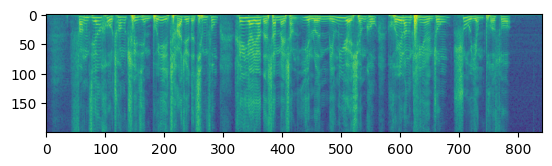

In [21]:
plt.imshow(fbank.T)
plt.show()

## 基于DFCNN和CTC损失函数的声学模型实现

In [23]:
!pip install --upgrade keras_applications==1.0.6 keras==2.2.4

Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple
You should consider upgrading via the '/home/ma-user/anaconda3/envs/TensorFlow-1.13-gpu/bin/python3.7 -m pip install --upgrade pip' command.


In [7]:
import keras
from keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D
from keras.layers import Reshape, Dense, Dropout, Lambda
from keras.optimizers import Adam
from keras import backend as K
from keras.models import Model
from tensorflow.contrib.training import HParams

In [9]:
# 定义卷积层
def conv2d(size):
    return Conv2D(size, (3, 3), use_bias=True, activation='relu',padding='same', kernel_initializer='he_normal')


# 定义 BN 层
def norm(x):
    return BatchNormalization(axis=-1)(x)


# 定义最大池化层
def maxpool(x):
    return MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(x)


# 定义 dense 层
def dense(units, activation="relu"):
    return Dense(units, activation=activation, use_bias=True, kernel_initializer='he_normal')


# 两个卷积层加一个最大池化层的组合
def cnn_cell(size, x, pool=True):
    x = norm(conv2d(size)(x))
    x = norm(conv2d(size)(x))
    if pool:
        x = maxpool(x)
    return x

#CTC 损失函数
def ctc_lambda(args):
    labels, y_pred, input_length, label_length = args
    y_pred = y_pred[:, :, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)



# 组合声学模型
class acoustic_model():
    def __init__(self, args):
        self.vocab_size = args.vocab_size
        self.learning_rate = args.learning_rate
        self.is_training = args.is_training
        self._model_init()
        if self.is_training:
            self._ctc_init()
            self.opt_init()

    def _model_init(self):
        self.inputs = Input(name='the_inputs', shape=(None, 200, 1))
        self.h1 = cnn_cell(32, self.inputs)
        self.h2 = cnn_cell(64, self.h1)
        self.h3 = cnn_cell(128, self.h2)
        self.h4 = cnn_cell(128, self.h3, pool=False)
        self.h5 = cnn_cell(128, self.h4, pool=False)
        # 200 / 8 * 128 = 3200
        self.h6 = Reshape((-1, 3200))(self.h5)
        self.h6 = Dropout(0.2)(self.h6)
        self.h7 = dense(256)(self.h6)
        self.h7 = Dropout(0.2)(self.h7)
        self.outputs = dense(self.vocab_size, activation='softmax')(self.h7)
        self.model = Model(inputs=self.inputs, outputs=self.outputs)

    def _ctc_init(self):
        self.labels = Input(name='the_labels', shape=[None], dtype='float32')
        self.input_length = Input(name='input_length', shape=[1], dtype='int64')
        self.label_length = Input(name='label_length', shape=[1], dtype='int64')
        self.loss_out = Lambda(ctc_lambda, output_shape=(1,), name='ctc')([self.labels, self.outputs, self.input_length, self.label_length])
        self.ctc_model = Model(inputs=[self.labels, self.inputs,self.input_length, self.label_length], outputs=self.loss_out)

    def opt_init(self):

        opt = Adam(lr=self.learning_rate, beta_1=0.9, beta_2=0.999, decay=0.01,epsilon=10e-8)
        self.ctc_model.compile(loss={'ctc': lambda y_true, output: output},optimizer=opt)
       
def acoustic_model_hparams():
    params = HParams(
        vocab_size=50,
        learning_rate=0.0008,
        is_training=True)
    return params


print("打印声学模型结构")
acoustic_model_args = acoustic_model_hparams()
acoustic = acoustic_model(acoustic_model_args)
acoustic.ctc_model.summary()


打印声学模型结构
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_inputs (InputLayer)         (None, None, 200, 1) 0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, None, 200, 32 320         the_inputs[0][0]                 
__________________________________________________________________________________________________
batch_normalization_11 (BatchNo (None, None, 200, 32 128         conv2d_11[0][0]                  
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, None, 200, 32 9248        batch_normalization_11[0][0]     
__________________________________________________________________________________________________
b

In [13]:
def data_hparams():
    params = HParams(
        data_path='./data_thchs30/data/',  # d 数据路径
        batch_size=1,  # 批尺寸
        data_length=None,  # 长度
    )
    return params


data_args = data_hparams()
data_args.data_length = 30  # 重新训练需要注释该行
train_data = get_data(data_args)  # 此处需要使用到数据集处理实验中定义的类别。
acoustic_model_args = acoustic_model_hparams()
acoustic_model_args.vocab_size = len(train_data.acoustic_vocab)
acoustic = acoustic_model(acoustic_model_args)
print('声学模型参数：')
print(acoustic_model_args)

声学模型参数：
[('is_training', True), ('learning_rate', 0.0008), ('vocab_size', 449)]


#### 开始训练

In [16]:
epochs = 20
batch_num = len(train_data.wav_lst) // train_data.batch_size
print("训练轮数 epochs：", epochs)
print("批数量 batch_num：", batch_num)
print("开始训练！")

for k in range(epochs):
    print('第', k + 1, '个 epoch')
    batch = train_data.get_acoustic_model_batch()
    acoustic.ctc_model.fit_generator(batch, steps_per_epoch=batch_num, epochs=1)
print("\n 训练完成，保存模型")
acoustic.ctc_model.save_weights('./data_thchs30/acoustic_model/model.h5')

训练轮数 epochs： 20
批数量 batch_num： 30
开始训练！
第 1 个 epoch
Epoch 1/1
30/30 [==============================] - 1s 40ms/step - loss: 0.6471
第 2 个 epoch
Epoch 1/1
30/30 [==============================] - 1s 38ms/step - loss: 0.5868
第 3 个 epoch
Epoch 1/1
30/30 [==============================] - 1s 38ms/step - loss: 0.7060
第 4 个 epoch
Epoch 1/1
30/30 [==============================] - 1s 39ms/step - loss: 0.5421
第 5 个 epoch
Epoch 1/1
30/30 [==============================] - 1s 37ms/step - loss: 0.4959
第 6 个 epoch
Epoch 1/1
30/30 [==============================] - 1s 39ms/step - loss: 0.5428
第 7 个 epoch
Epoch 1/1
30/30 [==============================] - 1s 38ms/step - loss: 0.5936
第 8 个 epoch
Epoch 1/1
30/30 [==============================] - 1s 38ms/step - loss: 0.5607
第 9 个 epoch
Epoch 1/1
30/30 [==============================] - 1s 38ms/step - loss: 0.5930
第 10 个 epoch
Epoch 1/1
30/30 [==============================] - 1s 38ms/step - loss: 0.4160
第 11 个 epoch
Epoch 1/1
30/30 [===================

#### Transformer

In [18]:
import keras
from keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D
from keras.layers import Reshape, Dense, Dropout, Lambda
from keras.optimizers import Adam
from keras import backend as K
from keras.models import Model
from easydict import EasyDict as edict
def HParams(**args):
    return edict(args)

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


def normalize(inputs,
              epsilon=1e-8,
              scope="ln",
              reuse=None):
    with tf.variable_scope(scope, reuse=reuse):
        inputs_shape = inputs.get_shape()
        params_shape = inputs_shape[-1:]
        mean, variance = tf.nn.moments(inputs, [-1], keep_dims=True)
        beta = tf.Variable(tf.zeros(params_shape))
        gamma = tf.Variable(tf.ones(params_shape))
        normalized = (inputs - mean) / ((variance + epsilon) ** (.5))
        outputs = gamma * normalized + beta
    return outputs

In [20]:
def embedding(inputs,
              vocab_size,
              num_units,
              zero_pad=True,
              scale=True,
              scope="embedding",
              reuse=None):
    with tf.variable_scope(scope, reuse=reuse):
        lookup_table = tf.get_variable('lookup_table',
                                       dtype=tf.float32,
                                       shape=[vocab_size, num_units],
                                       initializer=tf.keras.initializers.glorot_normal())
    if zero_pad:
        lookup_table = tf.concat((tf.zeros(shape=[1, num_units]),lookup_table[1:, :]), 0)
        
    outputs = tf.nn.embedding_lookup(lookup_table, inputs)
    
    if scale:
        outputs = outputs * (num_units ** 0.5)
    
    return outputs

In [22]:
def multihead_attention(emb,
                        queries,
                        keys,
                        num_units=None,
                        num_heads=8,
                        dropout_rate=0,
                        is_training=True,
                        causality=False,
                        scope="multihead_attention",
                        reuse=None):
    with tf.variable_scope(scope, reuse=reuse):
        if num_units is None:
            num_units = queries.get_shape().as_list[-1]

        Q = tf.layers.dense(queries, num_units, activation=tf.nn.relu)  # (N, T_q, C)
        K = tf.layers.dense(keys, num_units, activation=tf.nn.relu)  # (N, T_k, C)
        V = tf.layers.dense(keys, num_units, activation=tf.nn.relu)  # (N, T_k, C)

        Q_ = tf.concat(tf.split(Q, num_heads, axis=2), axis=0)  # (h*N, T_q, C/h)
        K_ = tf.concat(tf.split(K, num_heads, axis=2), axis=0)  # (h*N, T_k, C/h)
        V_ = tf.concat(tf.split(V, num_heads, axis=2), axis=0)  # (h*N, T_k, C/h)
        outputs = tf.matmul(Q_, tf.transpose(K_, [0, 2, 1]))  # (h*N, T_q, T_k)

        outputs = outputs / (K_.get_shape().as_list()[-1] ** 0.5)

        key_masks = tf.sign(tf.abs(tf.reduce_sum(emb, axis=-1)))  # (N, T_k)
        key_masks = tf.tile(key_masks, [num_heads, 1])  # (h*N, T_k)
        key_masks = tf.tile(tf.expand_dims(key_masks, 1), [1, tf.shape(queries)[1], 1])  #(h * N, T_q, T_k)

        paddings = tf.ones_like(outputs) * (-2 ** 32 + 1)
        outputs = tf.where(tf.equal(key_masks, 0), paddings, outputs)  # (h*N, T_q, T_k)

        if causality:
            diag_vals = tf.ones_like(outputs[0, :, :])  # (T_q, T_k)
            tril = tf.contrib.linalg.LinearOperatorTriL(diag_vals).to_dense()  # (T_q, T_k)
            masks = tf.tile(tf.expand_dims(tril, 0), [tf.shape(outputs)[0], 1, 1])  # (h*N,T_q, T_k)

            paddings = tf.ones_like(masks) * (-2 ** 32 + 1)
            outputs = tf.where(tf.equal(masks, 0), paddings, outputs)  # (h*N, T_q, T_k)

        outputs = tf.nn.softmax(outputs)  # (h*N, T_q, T_k)

        query_masks = tf.sign(tf.abs(tf.reduce_sum(emb, axis=-1)))  # (N, T_q)
        query_masks = tf.tile(query_masks, [num_heads, 1])  # (h*N, T_q)
        query_masks = tf.tile(tf.expand_dims(query_masks, -1), [1, 1, tf.shape(keys)[1]])
        # (h*N, T_q, T_k)
        outputs *= query_masks  # broadcasting. (N, T_q, C)

        outputs = tf.layers.dropout(outputs, rate=dropout_rate,
        training = tf.convert_to_tensor(is_training))

        outputs = tf.matmul(outputs, V_)  # ( h*N, T_q, C/h)

        outputs = tf.concat(tf.split(outputs, num_heads, axis=0), axis=2)  # (N, T_q, C)

        outputs += queries

        outputs = normalize(outputs)  # (N, T_q, C)
    return outputs

In [23]:
def feedforward(inputs,
                num_units=[2048, 512],
                scope="multihead_attention",
                reuse=None):
    
    with tf.variable_scope(scope, reuse=reuse):
        params = {"inputs": inputs, "filters": num_units[0], "kernel_size": 1,"activation": tf.nn.relu, "use_bias": True}
        outputs = tf.layers.conv1d(**params)


        params = {"inputs": outputs, "filters": num_units[1], "kernel_size": 1,"activation": None, "use_bias": True}
        outputs = tf.layers.conv1d(**params)

        outputs += inputs

        outputs = normalize(outputs)

    return outputs

In [24]:
def label_smoothing(inputs, epsilon=0.1):
    K = inputs.get_shape().as_list()[-1] # number of channels
    return ((1-epsilon) * inputs) + (epsilon / K)

#### 组合模型

In [25]:
# 组合语言模型
class language_model():
    def __init__(self, arg):

        self.graph = tf.Graph()
        with self.graph.as_default():
            self.is_training = arg.is_training
            self.hidden_units = arg.hidden_units
            self.input_vocab_size = arg.input_vocab_size
            self.label_vocab_size = arg.label_vocab_size
            self.num_heads = arg.num_heads
            self.num_blocks = arg.num_blocks
            self.max_length = arg.max_length
            self.learning_rate = arg.learning_rate
            self.dropout_rate = arg.dropout_rate

            self.x = tf.placeholder(tf.int32, shape=(None, None))
            self.y = tf.placeholder(tf.int32, shape=(None, None))
            self.emb = embedding(self.x, vocab_size=self.input_vocab_size,num_units=self.hidden_units, scale=True, scope="enc_embed")
            self.enc = self.emb +embedding(tf.tile(tf.expand_dims(tf.range(tf.shape(self.x)[1]), 0), [tf.shape(self.x)[0], 1]),vocab_size=self.max_length, num_units=self.hidden_units, zero_pad=False,
                                           scale=False, scope="enc_pe")
            self.enc = tf.layers.dropout(self.enc,rate = self.dropout_rate,training = tf.convert_to_tensor(self.is_training))

            for i in range(self.num_blocks):
                with tf.variable_scope("num_blocks_{}".format(i)):
                    self.enc = multihead_attention(emb=self.emb,queries = self.enc,keys = self.enc,num_units = self.hidden_units,num_heads = self.num_heads,dropout_rate = self.dropout_rate,is_training = self.is_training,causality = False)

            self.outputs = feedforward(self.enc, num_units=[4 * self.hidden_units,
                                                    self.hidden_units])

            self.logits = tf.layers.dense(self.outputs, self.label_vocab_size)
            self.preds = tf.to_int32(tf.argmax(self.logits, axis=-1))
            self.istarget = tf.to_float(tf.not_equal(self.y, 0))
            self.acc = tf.reduce_sum(tf.to_float(tf.equal(self.preds, self.y)) * self.istarget)/(tf.reduce_sum(self.istarget))
            tf.summary.scalar('acc', self.acc)

            if self.is_training:
                self.y_smoothed = label_smoothing(tf.one_hot(self.y,
                                                     depth=self.label_vocab_size))
                self.loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=self.logits,
                labels = self.y_smoothed)
                self.mean_loss = tf.reduce_sum(self.loss * self.istarget) / (tf.reduce_sum(self.istarget))

                self.global_step = tf.Variable(0, name='global_step', trainable=False)
                self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate,
                beta1 = 0.9, beta2 = 0.98, epsilon = 1e-8)
                self.train_op = self.optimizer.minimize(self.mean_loss,
                global_step = self.global_step)

                tf.summary.scalar('mean_loss', self.mean_loss)
                self.merged = tf.summary.merge_all()
print('语音模型建立完成！')

语音模型建立完成！


In [27]:
def language_model_hparams():
    params = HParams(
        num_heads=8,
        num_blocks=6,
        input_vocab_size=50,
        label_vocab_size=50,
        max_length=100,
        hidden_units=512,
        dropout_rate=0.2,
        learning_rate=0.0003,
        is_training=True)
    return params


language_model_args = language_model_hparams()
language_model_args.input_vocab_size = len(train_data.pin_vocab)
language_model_args.label_vocab_size = len(train_data.han_vocab)
language = language_model(language_model_args)
print('语言模型参数：')
print(language_model_args)

语言模型参数：
{'num_heads': 8, 'num_blocks': 6, 'input_vocab_size': 449, 'label_vocab_size': 585, 'max_length': 100, 'hidden_units': 512, 'dropout_rate': 0.2, 'learning_rate': 0.0003, 'is_training': True}


In [28]:
epochs = 20
batch_num = len(train_data.wav_lst) // train_data.batch_size
print("训练轮数 epochs：", epochs)
print("\n 开始训练！")
with language.graph.as_default():
    saver = tf.train.Saver()
    
with tf.Session(graph=language.graph) as sess:
    merged = tf.summary.merge_all()
    sess.run(tf.global_variables_initializer())
    if os.path.exists('/data_thchs30/language_model/model.meta'):
        print('加载语言模型')
        
        saver.restore(sess, './data_thchs30/language_model/model')
        
    writer = tf.summary.FileWriter('./data_thchs30/language_model/tensorboard',tf.get_default_graph())
        
    for k in range(epochs):
        total_loss = 0
        batch = train_data.get_language_model_batch()
        for i in range(batch_num):
            input_batch, label_batch = next(batch)
            feed = {language.x: input_batch, language.y: label_batch}
            cost, _ = sess.run([language.mean_loss, language.train_op], feed_dict=feed)
            total_loss += cost
            if (k * batch_num + i) % 10 == 0:
                rs = sess.run(merged, feed_dict=feed)
                writer.add_summary(rs, k * batch_num + i)
            print('第', k + 1, '个 epoch', ': average loss = ', total_loss / batch_num)
    print("\n 训练完成，保存模型")
    saver.save(sess, './data_thchs30/language_model/model')
writer.close()

训练轮数 epochs： 20

 开始训练！


2024-05-19 23:03:18.593528: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1512] Adding visible gpu devices: 0
2024-05-19 23:03:18.593589: I tensorflow/core/common_runtime/gpu/gpu_device.cc:984] Device interconnect StreamExecutor with strength 1 edge matrix:
2024-05-19 23:03:18.593597: I tensorflow/core/common_runtime/gpu/gpu_device.cc:990]      0 
2024-05-19 23:03:18.593603: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1003] 0:   N 
2024-05-19 23:03:18.593655: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 14259 MB memory) -> physical GPU (device: 0, name: Tesla T4, pci bus id: 0000:00:0d.0, compute capability: 7.5)


第 1 个 epoch : average loss =  0.23235255877176922
第 1 个 epoch : average loss =  0.45184990564982097
第 1 个 epoch : average loss =  0.6791176160176595
第 1 个 epoch : average loss =  0.9102951526641846
第 1 个 epoch : average loss =  1.1348759333292644
第 1 个 epoch : average loss =  1.351292085647583
第 1 个 epoch : average loss =  1.568052307764689
第 1 个 epoch : average loss =  1.7949202219645182
第 1 个 epoch : average loss =  2.008578395843506
第 1 个 epoch : average loss =  2.2082809448242187
第 1 个 epoch : average loss =  2.425528351465861
第 1 个 epoch : average loss =  2.6327592690785724
第 1 个 epoch : average loss =  2.852894926071167
第 1 个 epoch : average loss =  3.0540187199910482
第 1 个 epoch : average loss =  3.2654130776723225
第 1 个 epoch : average loss =  3.483798058827718
第 1 个 epoch : average loss =  3.669575834274292
第 1 个 epoch : average loss =  3.890231720606486
第 1 个 epoch : average loss =  4.087515513102214
第 1 个 epoch : average loss =  4.294742027918498
第 1 个 epoch : average loss =

#### 开始测试

In [53]:
data_args = data_hparams()
data_args.data_length = 20 # 重新训练需要注释该行
train_data = get_data(data_args)

In [54]:
test_data = get_data(data_args)
acoustic_model_batch = test_data.get_acoustic_model_batch()
language_model_batch = test_data.get_language_model_batch()

In [55]:
# 声学模型
acoustic_model_args = acoustic_model_hparams()
acoustic_model_args.vocab_size = 449
acoustic = acoustic_model(acoustic_model_args)
acoustic.ctc_model.summary()
acoustic.ctc_model.load_weights('./data_thchs30/acoustic_model/model.h5')

print("声学模型参数：")
print(acoustic_model_args)
print("加载声学模型完成！")

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_inputs (InputLayer)         (None, None, 200, 1) 0                                            
__________________________________________________________________________________________________
conv2d_81 (Conv2D)              (None, None, 200, 32 320         the_inputs[0][0]                 
__________________________________________________________________________________________________
batch_normalization_81 (BatchNo (None, None, 200, 32 128         conv2d_81[0][0]                  
__________________________________________________________________________________________________
conv2d_82 (Conv2D)              (None, None, 200, 32 9248        batch_normalization_81[0][0]     
__________________________________________________________________________________________________
batch_norm

In [56]:
# 语言模型
language_model_args = language_model_hparams()
language_model_args.input_vocab_size = 449
language_model_args.label_vocab_size = 585
language = language_model(language_model_args)
sess = tf.Session(graph=language.graph)
with language.graph.as_default():
    saver =tf.train.Saver()
with sess.as_default():
    saver.restore(sess, './data_thchs30/language_model/model')
print('语言模型参数：')
print(language_model_args)
print('\n 加载语言模型完成！')

INFO:tensorflow:Restoring parameters from ./data_thchs30/language_model/model


2024-05-19 23:32:24.015251: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1512] Adding visible gpu devices: 0
2024-05-19 23:32:24.015356: I tensorflow/core/common_runtime/gpu/gpu_device.cc:984] Device interconnect StreamExecutor with strength 1 edge matrix:
2024-05-19 23:32:24.015367: I tensorflow/core/common_runtime/gpu/gpu_device.cc:990]      0 
2024-05-19 23:32:24.015373: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1003] 0:   N 
2024-05-19 23:32:24.015448: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 14259 MB memory) -> physical GPU (device: 0, name: Tesla T4, pci bus id: 0000:00:0d.0, compute capability: 7.5)


语言模型参数：
{'num_heads': 8, 'num_blocks': 6, 'input_vocab_size': 449, 'label_vocab_size': 585, 'max_length': 100, 'hidden_units': 512, 'dropout_rate': 0.2, 'learning_rate': 0.0003, 'is_training': True}

 加载语言模型完成！


In [57]:
# 解码器
def decode_ctc(num_result, num2word):
    result = num_result[:, :, :]
    in_len = np.zeros((1), dtype = np.int32)
    in_len[0] = result.shape[1]
    t = K.ctc_decode(result, in_len, greedy = True, beam_width=10, top_paths=1)
    v = K.get_value(t[0][0])
    v = v[0]
    text = []
    for i in v:
         text.append(num2word[i])
    return v, text

##### 开始测试

In [60]:
for i in range(10):
    print('\n 示例', i+1)
    # 载入训练好的模型，并进行识别
    inputs, outputs = next(acoustic_model_batch)
    x = inputs['the_inputs']
    y = inputs['the_labels'][0]
    result = acoustic.model.predict(x, steps=1)
    # 将数字结果转化为文本结果
    
    _, text = decode_ctc(result, train_data.acoustic_vocab)
    text = ' '.join(text)
    print('原文拼音：', ' '.join([train_data.acoustic_vocab[int(i)] for i in y]))
    print('识别结果：', text)
    with sess.as_default():
        try:
            _, y = next(language_model_batch)
            text = text.strip('\n').split(' ')
            x = np.array([train_data.pin_vocab.index(pin) for pin in text])
            x = x.reshape(1, -1)
            preds = sess.run(language.preds, {language.x: x})
            got = ''.join(train_data.han_vocab[idx] for idx in preds[0])
            print('原文汉字：', ''.join(train_data.han_vocab[idx] for idx in y[0]))
            print('识别结果：', got)
        except StopIteration:
            continue
sess.close()


 示例 1
原文拼音： guang3 zhou1 yue4 ju4 er4 tuan2 cong2 nian2 chu1 er4 qi3 zai4 pan1 yu3 yan3 chu1 hou4 jiang1 yao4 dao4 yue4 dong1 shan1 qu1 mei2 zhou1 he2 yuan2 xian4 yi4
识别结果： guang3 zhou1 yue4 ju4 er4 tuan2 cong2 nian2 chu1 er4 qi3 zai4 pan1 yu3 yan3 chu1 hou4 jiang1 yao4 dao4 yue4 dong1 shan1 qu1 mei2 zhou1 he2 yuan2 xian4 teng2 yi4


RuntimeError: Attempted to use a closed Session.